In [1]:
import pandas as pd
import numpy as np

from source.report import report_points, report_victory, yearly_wrapper

from sklearn.metrics import log_loss

In [2]:
logit = pd.read_csv('oof/2021_women_logit_2019.csv')
boost = pd.read_csv('oof/2021_women_xgboost_2019.csv')

logit.head()

,delta_Score,delta_opp_score,delta_Blk,delta_Stl,delta_def_rating,delta_possessions,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed,true_label,oof_pred,Season
0,4.643750,2.575000,0.033333,-3.304167,7.719235,-2.747344,0,0,-143.220851,-13.510990,1,0.806887,2019
1,12.190524,9.174395,-1.822581,-0.637097,3.362166,7.351966,0,0,49.749059,17.485552,1,0.287326,2019
2,-7.225806,6.419355,0.387097,3.064516,2.052454,6.707258,0,0,5.010121,21.724989,1,0.275934,2019
3,15.231061,-11.299242,-2.222538,-0.700758,-11.273988,-2.820147,1,0,-352.148044,-179.204997,1,0.998960,2019
4,3.995112,-3.190616,0.488759,1.379277,-5.109695,0.154888,0,0,118.166309,112.460955,0,0.292096,2019


In [3]:
boost.head()

,T1_Score,T2_Score,T1_opp_score,T2_opp_score,T1_FGM_perc,T2_FGM_perc,T1_Seed,T2_Seed,T1_Stl,T2_Stl,...,T1_TO,T2_TO,T1_Away,T2_Away,seed_round1,off_edge_Seed,def_edge_Seed,true_label,oof_pred,Season
0,66.300000,61.656250,58.200000,55.625000,0.423748,0.416621,5.0,12.0,6.633333,9.937500,...,12.333333,15.843750,0.300000,0.468750,0,-143.220851,-13.510990,1,0.733053,2019
1,76.093750,63.903226,66.593750,57.419355,0.413386,0.417995,10.0,7.0,9.750000,10.387097,...,15.031250,15.741935,0.437500,0.290323,0,49.749059,17.485552,1,0.383876,2019
2,69.032258,76.258065,66.419355,60.000000,0.421518,0.451385,9.0,8.0,11.483871,8.419355,...,19.870968,13.354839,0.225806,0.451613,0,5.010121,21.724989,1,0.335620,2019
3,82.606061,67.375000,54.575758,65.875000,0.493488,0.389915,2.0,15.0,8.424242,9.125000,...,11.727273,17.593750,0.575758,0.375000,1,-352.148044,-179.204997,1,0.950778,2019
4,72.575758,68.580645,57.454545,60.645161,0.460086,0.411181,12.0,5.0,9.121212,7.741935,...,14.757576,13.548387,0.393939,0.354839,0,118.166309,112.460955,0,0.363965,2019


In [5]:
log_pred = logit[['true_label', 'oof_pred']].copy()
log_pred.columns = ['true_label_logit', 'logit_pred']
xgb_pred = boost[['true_label', 'oof_pred']].copy()
xgb_pred.columns = ['true_label', 'xgb_pred']

all_pred = pd.concat([log_pred, xgb_pred], axis=1)

assert (all_pred.true_label_logit == all_pred.true_label).all()
del all_pred['true_label_logit']

all_pred.head()

,logit_pred,true_label,xgb_pred
0,0.806887,1,0.733053
1,0.287326,1,0.383876
2,0.275934,1,0.335620
3,0.998960,1,0.950778
4,0.292096,0,0.363965


In [6]:
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)
print(all_pred['accord'].mean())

print(f'Logit: \t{log_loss(y_pred=all_pred.logit_pred, y_true=all_pred.true_label)}')
print(f'Xgb: \t{log_loss(y_pred=all_pred.xgb_pred, y_true=all_pred.true_label)}')
print(f'Mean: \t{log_loss(y_pred=all_pred.mean_pred, y_true=all_pred.true_label)}')

all_pred.head()

0.9444444444444444
Logit: 	0.370622538607947
Xgb: 	0.3826027240694626
Mean: 	0.37464926259489884


,logit_pred,true_label,xgb_pred,mean_pred,accord_win,accord_loss,accord
0,0.806887,1,0.733053,0.769970,1,0,1
1,0.287326,1,0.383876,0.335601,0,1,1
2,0.275934,1,0.335620,0.305777,0,1,1
3,0.998960,1,0.950778,0.974869,1,0,1
4,0.292096,0,0.363965,0.328031,0,1,1


In [7]:
all_pred['boostsure'] = all_pred.xgb_pred

all_pred.loc[((all_pred.logit_pred > 0.65) & (all_pred.xgb_pred > 0.65)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.35) & (all_pred.xgb_pred < 0.35)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

print(f'Boost sure: \t{log_loss(y_pred=all_pred.boostsure, y_true=all_pred.true_label)}')

all_pred.head()

Boost sure: 	0.4006705423414341


,logit_pred,true_label,xgb_pred,mean_pred,accord_win,accord_loss,accord,boostsure
0,0.806887,1,0.733053,0.769970,1,0,1,0.883053
1,0.287326,1,0.383876,0.335601,0,1,1,0.383876
2,0.275934,1,0.335620,0.305777,0,1,1,0.185620
3,0.998960,1,0.950778,0.974869,1,0,1,0.970000
4,0.292096,0,0.363965,0.328031,0,1,1,0.363965


In [8]:
all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.65) & (all_pred.xgb_pred < 0.65)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.35) & (all_pred.xgb_pred > 0.35)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

print(f'Boost sure: \t{log_loss(y_pred=all_pred.avg_boost, y_true=all_pred.true_label)}')

all_pred.head()

Boost sure: 	0.39962766664269583


,logit_pred,true_label,xgb_pred,mean_pred,accord_win,accord_loss,accord,boostsure,avg_boost
0,0.806887,1,0.733053,0.769970,1,0,1,0.883053,0.883053
1,0.287326,1,0.383876,0.335601,0,1,1,0.383876,0.383876
2,0.275934,1,0.335620,0.305777,0,1,1,0.185620,0.185620
3,0.998960,1,0.950778,0.974869,1,0,1,0.970000,0.970000
4,0.292096,0,0.363965,0.328031,0,1,1,0.363965,0.363965


2015
Accord: 	0.9603174603174603
Logit: 		0.3713556989453982
Xgb: 		0.3919165754790432
Mean: 		0.3790038311066226
Boost sure: 	0.4198680240859607
Boost sure+mean: 0.42029409967213405
No uncertain: 0.4128346931554752
Accuracy train: 		 0.8333
Accuracy test: 			 0.8333
Logloss train: 			 0.4128
Logloss test: 			 0.4199
Unsure train: 			 8.7302%
Unsure test: 			 14.2857%


________________________________________


2016
Accord: 	0.9523809523809523
Logit: 		0.45593652878031604
Xgb: 		0.5353669215198881
Mean: 		0.4880787179713304
Boost sure: 	0.5561403762974312
Boost sure+mean: 0.5570050403246112
No uncertain: 0.5658898479134044
Accuracy train: 		 0.7143
Accuracy test: 			 0.7143
Logloss train: 			 0.5659
Logloss test: 			 0.5561
Unsure train: 			 14.2857%
Unsure test: 			 19.8413%


________________________________________


2017
Accord: 	0.9603174603174603
Logit: 		0.4446552067980825
Xgb: 		0.48972515502206887
Mean: 		0.4635592390054829
Boost sure: 	0.5094752231412475
Boost sure+mean: 0.5

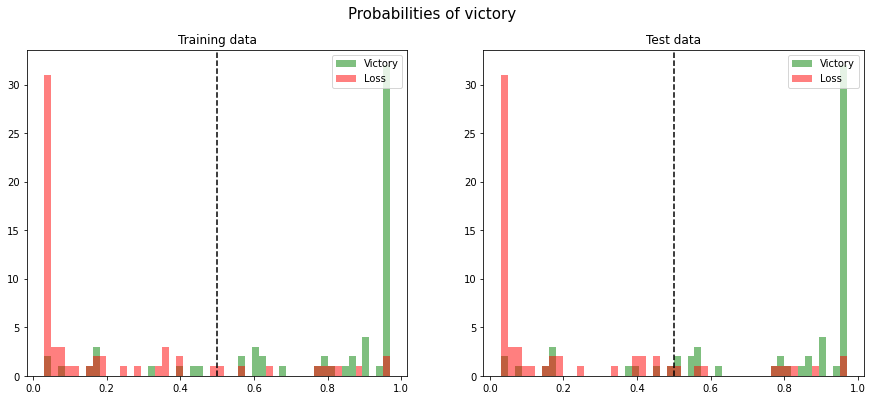

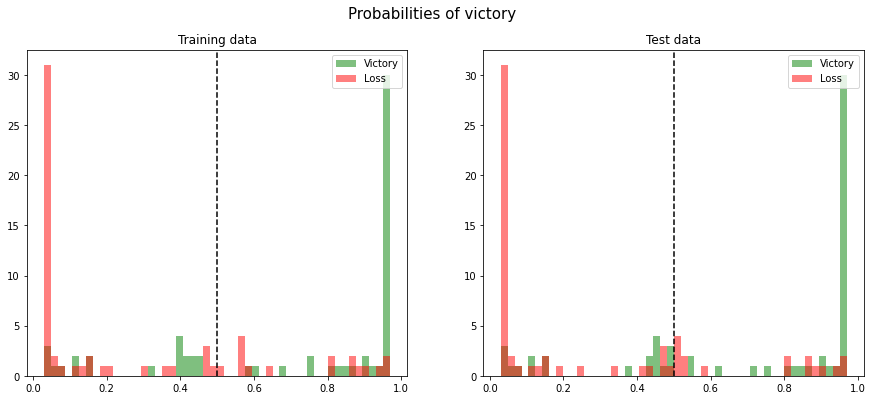

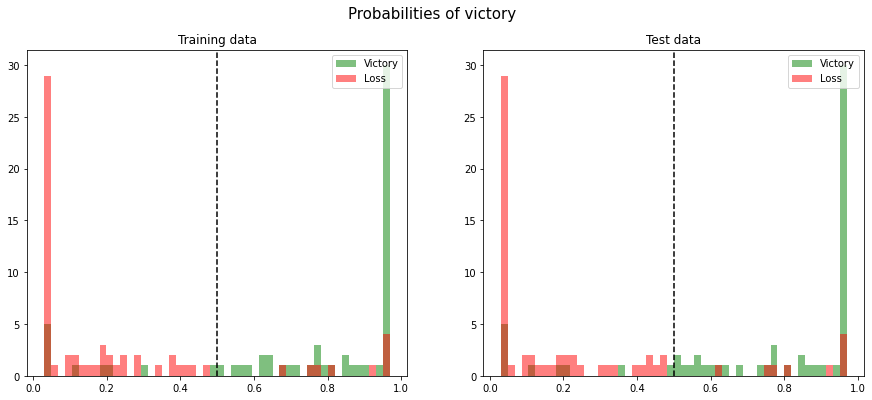

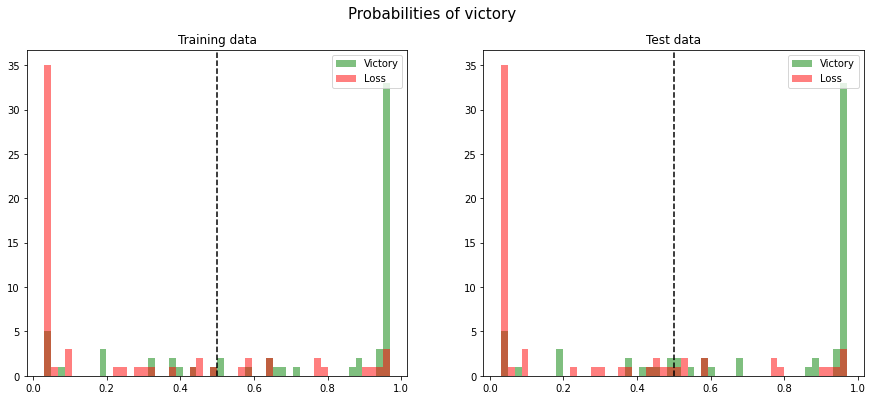

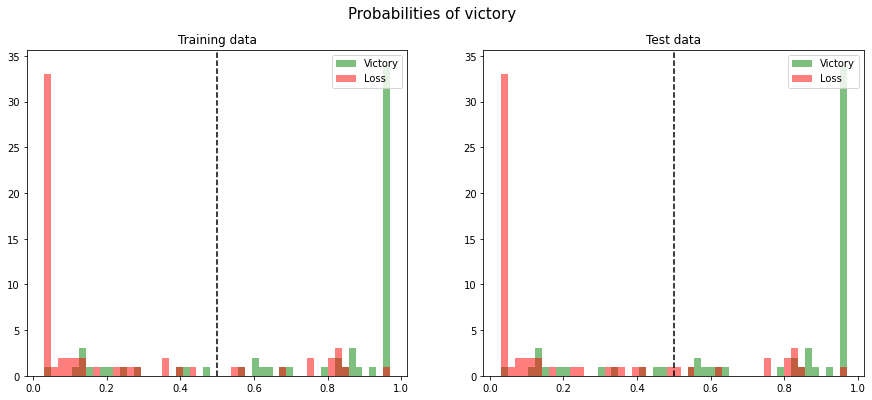

In [2]:
for yr in [2015, 2016, 2017, 2018, 2019]:
    lim = 0.1
    
    logit = pd.read_csv(f'oof/2021_women_logit_{yr}.csv')
    boost = pd.read_csv(f'oof/2021_women_xgboost_{yr}.csv')
    log_pred = logit[['true_label', 'oof_pred']].copy()
    log_pred.columns = ['true_label_logit', 'logit_pred']
    xgb_pred = boost[['true_label', 'oof_pred']].copy()
    xgb_pred.columns = ['true_label', 'xgb_pred']

    all_pred = pd.concat([log_pred, xgb_pred], axis=1)

    assert (all_pred.true_label_logit == all_pred.true_label).all()
    del all_pred['true_label_logit']
    all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

    all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
    all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
    all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)
    
    all_pred['boostsure'] = all_pred.logit_pred

    all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
    all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
    all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)
    
    all_pred['avg_boost'] = all_pred.boostsure

    all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
                  (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
    all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
                  (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
    all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)
    
    all_pred['no_uncertain'] = all_pred.boostsure
    
    all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
                  ((all_pred.logit_pred < 0.5+lim) | (all_pred.xgb_pred < 0.5+lim))), 'no_uncertain'] = all_pred['no_uncertain'] + 0.05
    all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
                  ((all_pred.logit_pred > 0.5-lim) | (all_pred.xgb_pred > 0.5-lim))), 'no_uncertain'] = all_pred['no_uncertain'] - 0.05
    all_pred['no_uncertain'] = np.clip(all_pred['no_uncertain'], 0.03, 0.97)
    
    print(yr)
    print(f'Accord: \t{all_pred.accord.mean()}')
    print(f'Logit: \t\t{log_loss(y_pred=all_pred.logit_pred, y_true=all_pred.true_label)}')
    print(f'Xgb: \t\t{log_loss(y_pred=all_pred.xgb_pred, y_true=all_pred.true_label)}')
    print(f'Mean: \t\t{log_loss(y_pred=all_pred.mean_pred, y_true=all_pred.true_label)}')
    print(f'Boost sure: \t{log_loss(y_pred=all_pred.boostsure, y_true=all_pred.true_label)}')
    print(f'Boost sure+mean: {log_loss(y_pred=all_pred.avg_boost, y_true=all_pred.true_label)}')
    print(f'No uncertain: {log_loss(y_pred=all_pred.no_uncertain, y_true=all_pred.true_label)}')
    report_victory(all_pred.true_label, all_pred.true_label, all_pred.no_uncertain, all_pred.boostsure, probs=True, plot=True)
    print('\n')
    print('_'*40)
    print('\n')

2019
Accord: 	0.9338624338624338
Logit: 		0.4221731416826028
Xgb: 		0.44297301025311653
Mean: 		0.4273432263469811
Boost sure: 	0.4439618307865492
Boost sure+mean: 0.437348615319797
Accuracy train: 		 0.7901
Accuracy test: 			 0.7901
Logloss train: 			 0.444
Logloss test: 			 0.444
Unsure train: 			 16.5785%
Unsure test: 			 16.5785%


________________________________________




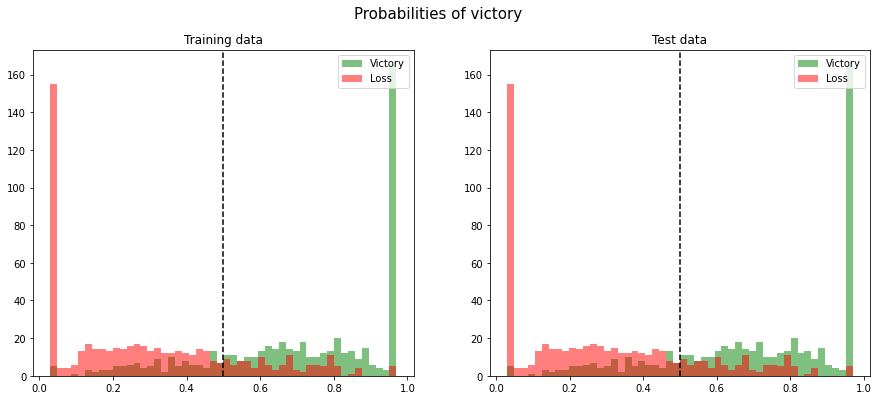

In [24]:
logit = pd.read_csv(f'oof/2021_women_logit_oof.csv')
boost = pd.read_csv(f'oof/2021_women_xgb_oof.csv')
log_pred = logit[['true_label', 'oof_pred']].copy()
log_pred.columns = ['true_label_logit', 'logit_pred']
xgb_pred = boost[['true_label', 'oof_pred']].copy()
xgb_pred.columns = ['true_label', 'xgb_pred']

all_pred = pd.concat([log_pred, xgb_pred], axis=1)

assert (all_pred.true_label_logit == all_pred.true_label).all()
del all_pred['true_label_logit']
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)

all_pred['boostsure'] = all_pred.xgb_pred

all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

print(yr)
print(f'Accord: \t{all_pred.accord.mean()}')
print(f'Logit: \t\t{log_loss(y_pred=all_pred.logit_pred, y_true=all_pred.true_label)}')
print(f'Xgb: \t\t{log_loss(y_pred=all_pred.xgb_pred, y_true=all_pred.true_label)}')
print(f'Mean: \t\t{log_loss(y_pred=all_pred.mean_pred, y_true=all_pred.true_label)}')
print(f'Boost sure: \t{log_loss(y_pred=all_pred.boostsure, y_true=all_pred.true_label)}')
print(f'Boost sure+mean: {log_loss(y_pred=all_pred.avg_boost, y_true=all_pred.true_label)}')
report_victory(all_pred.true_label, all_pred.true_label, all_pred.boostsure, all_pred.boostsure, probs=True, plot=True)
print('\n')
print('_'*40)
print('\n')